# Creating Digitally Reconstructed Radiographs (DRRs) using `DiffDRR`:
---

### Creating DRR and rendering 2D visualizations

In [1]:
# Import libraries
import sys

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr, plot_mask
from diffdrr.data import read

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# Get transforms
transform = get_transforms(contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data",
    collection="HCC-TACE-Seg",
    transform=transform,
    download_len=5,
    val_frac=0.2,
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Get datalists
train_dl = train_ds.datalist
val_dl = val_ds.datalist

# Check length of datasets, dataloaders and datalists
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))
print(len(train_dl), len(val_dl))

2024-05-02 18:57:33,570 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-05-02 18:57:33,570 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-05-02 18:57:33,570 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-05-02 18:57:34,056 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-05-02 18:57:34,057 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-05-02 18:57:34,058 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-05-02 18:57:34,313 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [3]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

print(image.shape, seg.shape)
print(image.dtype, seg.dtype)

torch.Size([1, 1, 512, 512, 89]) torch.Size([1, 1, 512, 512, 89])
torch.float32 torch.int32


In [4]:
image.shape

torch.Size([1, 1, 512, 512, 89])

In [5]:
labels = [0, 1, 2, 3, 4]

# structures = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]
# labels = subject.structures.query(f"group in {structures}")["id"].tolist()

# Read in CT volume and label map
subject = read(tensor=image[0], label_tensor=seg[0], orientation="AP", bone_attenuation_multiplier=5)

In [6]:
from src.drr import create_drr

img = create_drr(
    volume=image[0],
    segmentation=seg[0],
    sdd=1020,
    height=200,
    width=200,
    delx=2.0,
    dely=2.0,
    x0=0,
    y0=0,
    reverse_x_axis=True,
    patch_size=None,
    renderer="siddon",
    rotations=torch.tensor([[0.0, 0.0, 0.0]]),
)

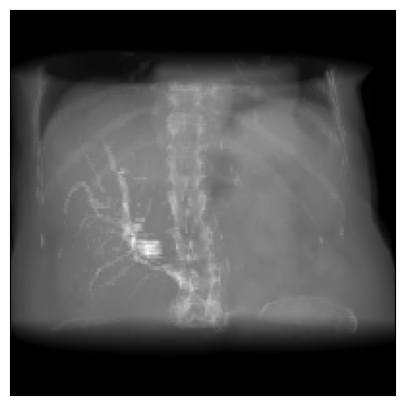

In [7]:
im = img.sum(dim=1, keepdim=True)
drr_image = plot_drr(im, ticks=False)

In [8]:
# Or read in CT volume and label map from datalist path
subject_path = read(
    filename=train_dl[0]["image"],
    orientation="AP",
    bone_attenuation_multiplier=5,
)

In [9]:
# Create a DRR object
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample = None,  # Proportion of pixels to randomly subsample
    reshape = True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis = True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size = None,  # Render patches of the DRR in series
    renderer = "siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

tensor([[0.3491, 0.0000, 0.0000]], device='cuda:0')
RigidTransform()


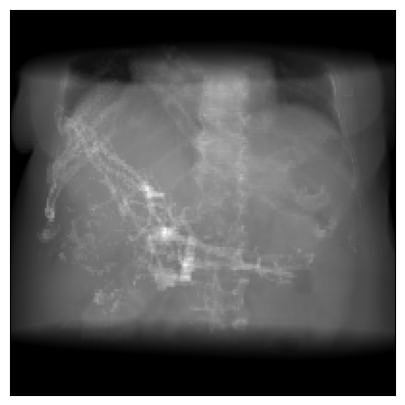

In [10]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)

zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 800.0, 0.0]], device=device)
#rotations = torch.tensor([[torch.pi / 2, torch.pi / 6, 0.0]], device=device)
rotations = torch.tensor([[20.0, 0.0, 0.0]], device=device)
rotations = torch.deg2rad(rotations)
print(rotations)
pose1 = convert(zero, translations, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rotations, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)
print(pose)

img = drr(pose, mask_to_channels = True)

im = img.sum(dim=1, keepdim=True)
plot_drr(im, ticks=False)
plt.show()

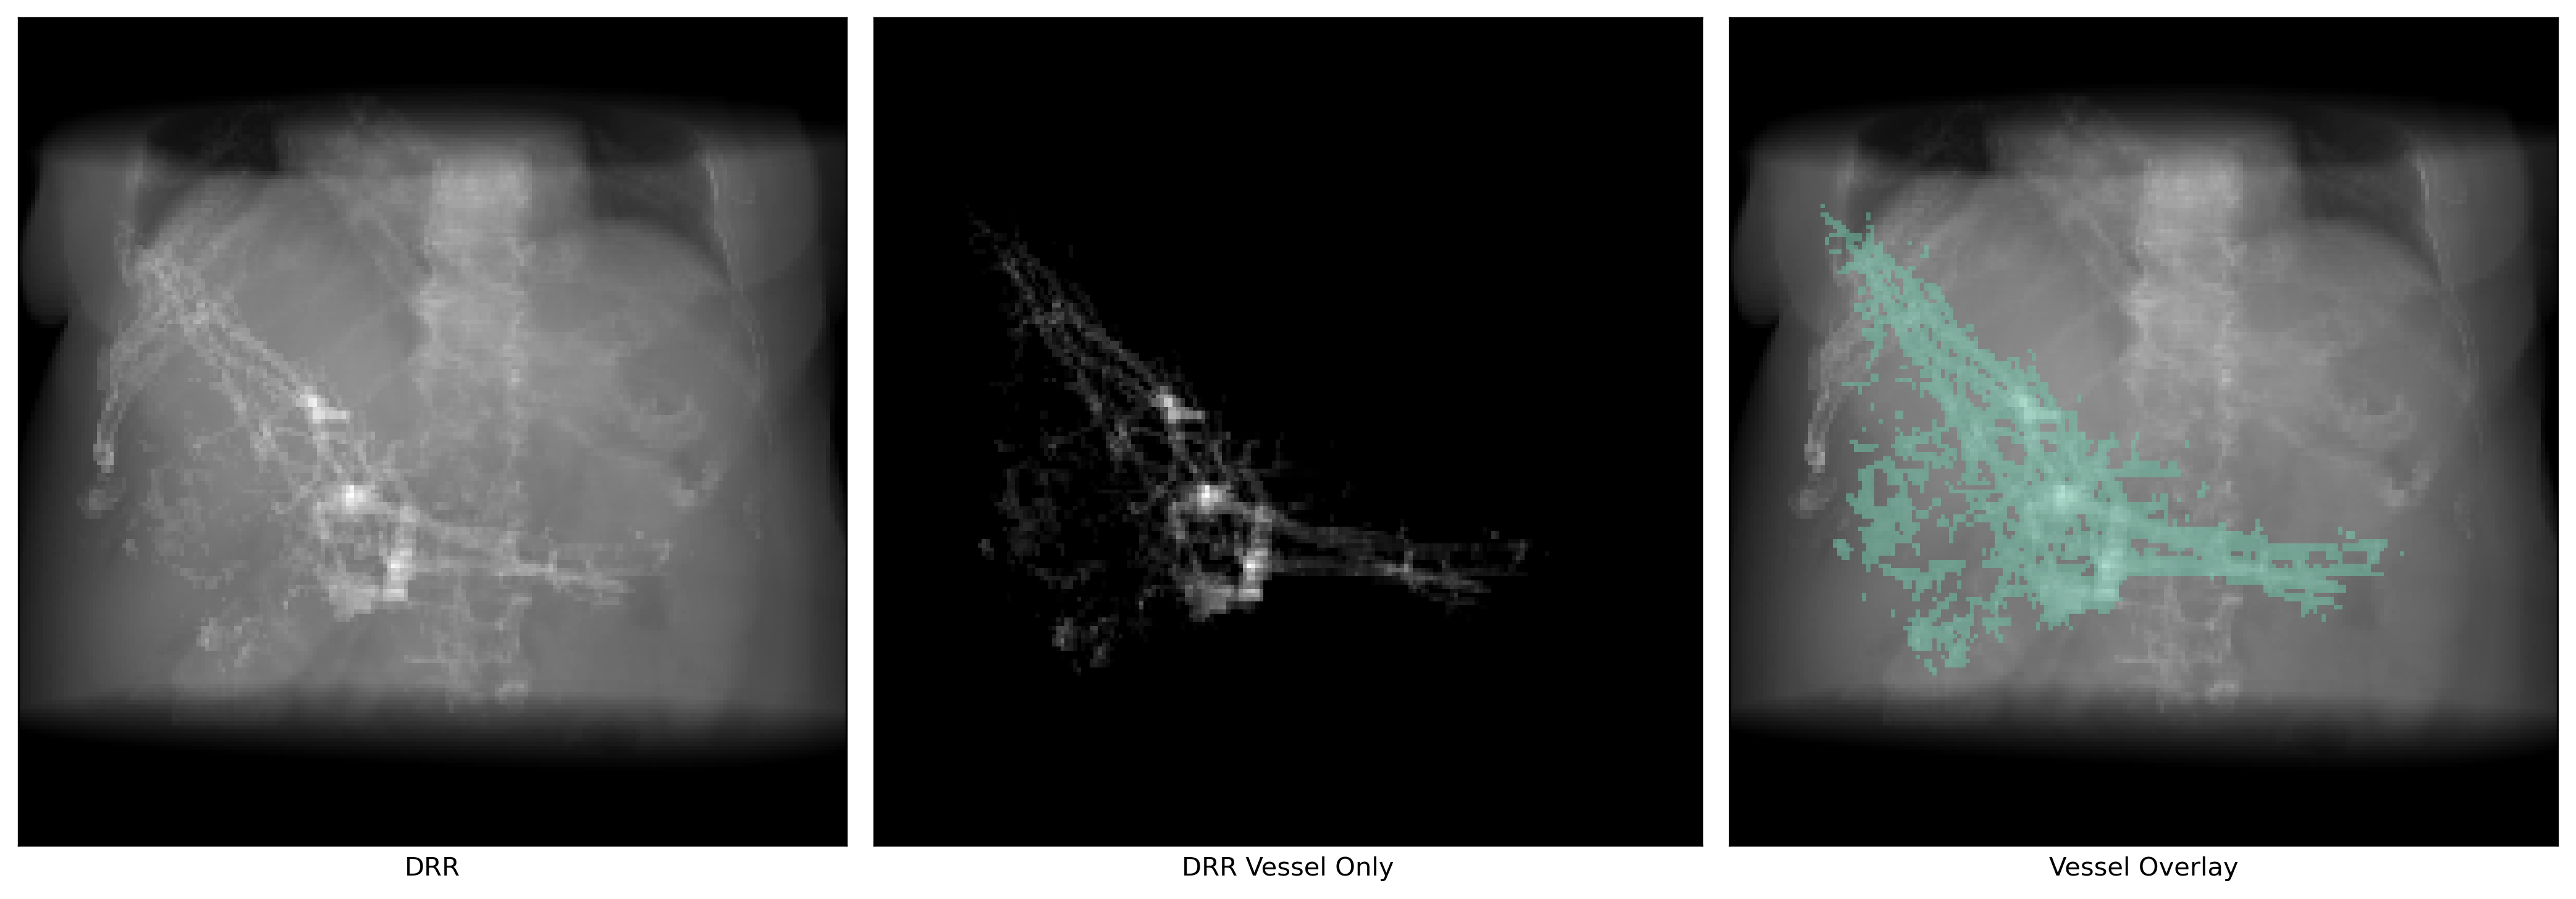

In [11]:
labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]

# Plot the segmentation masks
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(14, 7.75),
    tight_layout=True,
    dpi=300,
)

im = img.sum(dim=1, keepdim=True)
plot_drr(im, axs=axs[0], ticks=False, title="DRR")
plot_drr(
    img[:, 2, :, :].unsqueeze(dim=1), axs=axs[1], ticks=False, title="DRR Vessel Only"
)
plot_drr(im, axs=axs[2], ticks=False, title="Vessel Overlay")

for idx, label in enumerate(labels):
    if label == "Portal vein":
        mask = img[:, idx, :, :].unsqueeze(dim=1)
        vessel_mask = plot_mask(mask, axs=axs[2], alpha=0.5, return_masks=True)

In [12]:
print(vessel_mask[:,:,:,:,3].unique())
print(vessel_mask.shape)

print(img.shape)
print(img.unique()) 


tensor([  0, 255], dtype=torch.uint8)
torch.Size([1, 1, 200, 200, 4])
torch.Size([1, 5, 200, 200])
tensor([0.0000e+00, 5.9141e-06, 5.9159e-06,  ..., 2.7095e+01, 2.7420e+01,
        2.8238e+01], device='cuda:0')


### Creating 3D mesh renders and 3D to 2D projections:

In [13]:
# Make a mesh from the CT volume
ct = drr_to_mesh(subject, "surface_nets", threshold=225, verbose=True)

Performing Labeled Surface Extraction: 100%|██████████[00:01<00:00]
Finding and Labeling Connected Regions.: 100%|██████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|██████████[00:03<00:00]
Filling Holes: 100%|██████████[00:00<00:00]
Cleaning: 100%|██████████[00:00<00:00]


tensor([[1.5708, 0.5236, 0.0000]], device='cuda:0')
RigidTransform()


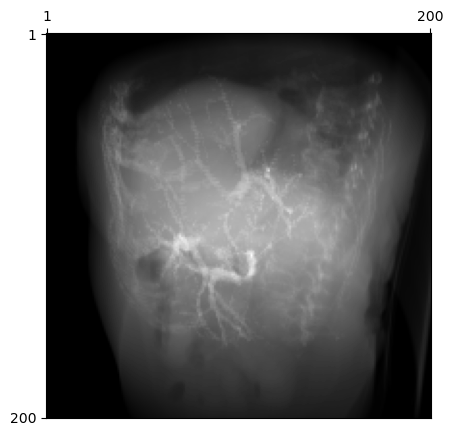

In [14]:
# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device)

# Make a pose
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 800.0, 0.0]], device=device)
rot = torch.tensor([[torch.pi / 2, torch.pi / 6, 0.0]], device=device)
print(rot)
pose1 = convert(zero, xyz, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rot, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)
print(pose)

plot_drr(drr(pose))
plt.show()

In [15]:
# Make a mesh from the camera and detector plane
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
# plotter.export_html("render.html")

Widget(value='<iframe src="http://localhost:59713/index.html?ui=P_0x222e83f4850_0&reconnect=auto" class="pyvis…

### Registrating random X-ray pose to reference:

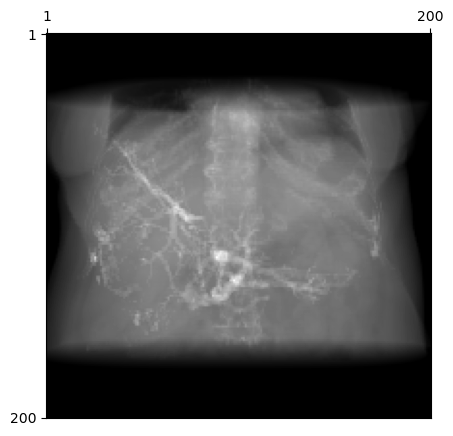

In [16]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from diffdrr.metrics import (
    MultiscaleNormalizedCrossCorrelation2d,
    NormalizedCrossCorrelation2d,
)
from diffdrr.registration import Registration

# Make the ground truth X-ray
SDD = 1020.0
HEIGHT = 200
DELX = 2.0

true_params = {
    "sdr": SDD,
    "alpha": 0.0,
    "beta": 0.0,
    "gamma": 0.0,
    "bx": 0.0,
    "by": 850.0,
    "bz": 0.0,
}
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
rotations = torch.tensor(
    [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
    ]
).to(device)
translations = torch.tensor(
    [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
    ]
).to(device)
ground_truth = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZXY",
)

plot_drr(ground_truth)
plt.show()

In [17]:
from diffdrr.pose import convert


def pose_from_carm(sid, tx, ty, alpha, beta, gamma):
    rot = torch.tensor([[alpha, beta, gamma]])
    xyz = torch.tensor([[tx, sid, ty]])
    return _pose_from_carm(rot, xyz)


def _pose_from_carm(rot, xyz):
    zero = torch.tensor([[0.0, 0.0, 0.0]]).to(rot)
    R = convert(
        rot,
        zero,
        parameterization="euler_angles",
        convention="ZXY",
    )
    t = convert(
        zero,
        xyz,
        parameterization="euler_angles",
        convention="ZXY",
    )
    return t.compose(R)


gt_pose = _pose_from_carm(rotations, translations)

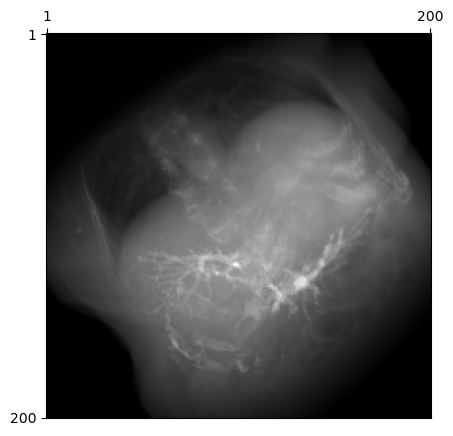

In [18]:
# Make a random DRR
np.random.seed(5)


def get_initial_parameters(true_params):
    alpha = true_params["alpha"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    beta = true_params["beta"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    bx = true_params["bx"] + np.random.uniform(-30.0, 30.0)
    by = true_params["by"] + np.random.uniform(-30.0, 30.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 30.0)
    pose = pose_from_carm(by, bx, bz, alpha, beta, gamma).cuda()
    # rotations, translations = pose.convert("euler_angles", "ZXY")
    rotations = torch.tensor([[alpha, beta, gamma]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    return rotations, translations, pose


rotations, translations, pose = get_initial_parameters(true_params)
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(pose)
plot_drr(est)
plt.show()

In [19]:
criterion = NormalizedCrossCorrelation2d()
criterion(ground_truth, est).item()

0.737350344657898

In [20]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=5e-2,
    lr_translations=1e2,
    momentum=0,
    dampening=0,
    n_itrs=1,
    optimizer="sgd",  # 'sgd' or `adam`
):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
    else:
        optimizer = torch.optim.Adam(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            maximize=True,
        )

    params = []
    losses = []
    for itr in tqdm(range(n_itrs), ncols=50):
        # Save the current set of parameters
        alpha, beta, gamma = reg.rotation.squeeze().tolist()
        bx, by, bz = reg.translation.squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        loss = criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())

        if loss > 0.999:
            tqdm.write(f"Converged in {itr} iterations")
            break

    plt.show()
    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

In [21]:
# Base SGD
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_base = optimize(reg, ground_truth)
print(params_base["loss"].iloc[-1])
del drr

# SGD + momentum
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum = optimize(reg, ground_truth, momentum=1e-1)
print(params_momentum["loss"].iloc[-1])
del drr

# SGD + momentum + dampening
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum_dampen = optimize(reg, ground_truth, momentum=1e-1, dampening=1e-2)
print(params_momentum_dampen["loss"].iloc[-1])
del drr

# Adam
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_adam = optimize(reg, ground_truth, 1e-1, 1e1, optimizer="adam")
print(params_adam["loss"].iloc[-1])
del drr

100%|███████████████| 1/1 [00:01<00:00,  1.11s/it]


0.7371280193328857


100%|███████████████| 1/1 [00:01<00:00,  1.30s/it]


0.7371280193328857


100%|███████████████| 1/1 [00:01<00:00,  1.33s/it]


0.7371280193328857


100%|███████████████| 1/1 [00:01<00:00,  1.34s/it]

0.7371280193328857


In [22]:
from base64 import b64encode

from IPython.display import HTML, display

from diffdrr.visualization import animate


def animate_in_browser(df):
    n = MAX_LENGTH - len(df)
    df = pd.concat([df, df.iloc[[-1] * n]])

    out = animate(
        "<bytes>",
        df,
        drr,
        ground_truth=ground_truth,
        verbose=True,
        device=device,
        extension=".webp",
        duration=30,
        parameterization="euler_angles",
        convention="ZXY",
    )
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))


MAX_LENGTH = max(
    map(
        len,
        [
            params_base,
            params_momentum,
            params_momentum_dampen,
            params_adam,
        ],
    )
)
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)

In [23]:
# Will only run in browser based Jupyter notebooks
animate_in_browser(params_base)

Precomputing DRRs: 100%|█████████████████████| 1/1 [00:01<00:00,  1.14s/it]


In [24]:
from src.drr import create_drr